# Prerequisites

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
from datetime import datetime, timedelta
import numpy as np
import random
import torch

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


is_on_colab = False

In [2]:
# Optiional: Connect to Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    timenow = datetime.now()+timedelta(hours=-7)
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Chronical/2024_07/PNC_Capstone")
    is_on_colab = True
else:
    print('Running on Local')
    timenow = datetime.now()
    is_on_colab = False

timenow_str = f"{timenow.hour:02d}{timenow.minute:02d}{timenow.month:02d}{timenow.day:02d}"

Running on Local


In [3]:
import Hypers
importlib.reload(Hypers)
import utils
importlib.reload(utils)
import Trainer
importlib.reload(Trainer)

utils.fix_random_seed(1127)#Hypers.Config.seed)

if is_on_colab:
  Hypers.Config.base_path = os.getcwd()
  Hypers.Config.data_path = os.path.join(Hypers.Config.base_path, "data")
  Hypers.Config.model_path = os.path.join(Hypers.Config.base_path, "model")
  Hypers.Config.log_path = os.path.join(Hypers.Config.base_path, "log")

print(f"{Hypers.Config.base_path=}")
print(f"{Hypers.Config.data_path=}")
print(f"{Hypers.Config.model_path=}")
print(f"{Hypers.Config.log_path=}")

Hypers.Config.base_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone'
Hypers.Config.data_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\data'
Hypers.Config.model_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\model'
Hypers.Config.log_path='c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\log'


In [4]:
suffix = "Ret"
window_size = 4

In [5]:
import CompustatExtractor
importlib.reload(CompustatExtractor)
from CompustatExtractor import CompustatExtractor

dataset_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}.pkl")
dataset_noCPI_path = os.path.join(Hypers.Config.data_path, "WRDS", f"dataset_{suffix}_noCPI.pkl")

features = CompustatExtractor.process_compustat_features(
	os.path.join(Hypers.Config.data_path, "WRDS", f"features_{suffix}.csv"),
	save=False,
	filestem=f"features_{suffix}",
	add_cpi=True
)

concatenate_features = CompustatExtractor.concatenate_features(features, k=window_size)

ratings = CompustatExtractor.process_compustat_ratings(
	os.path.join(Hypers.Config.data_path, "WRDS", f"ratings_{suffix}.csv"),
	save=False,
	filestem=f"ratings_{suffix}"
)

merged_dict = CompustatExtractor.merge_input_output_dicts(
	concatenate_features,
	ratings,
	save=True,
	filestem=f"dataset_{suffix}"
)


input_dict: 49
output_dict: 37
merged_dict: 37


### Data preprocessing

In [6]:
import itertools

preprocessing_options = [
    {"standardize": True, "power_transformation": True},
    {"standardize": True, "power_transformation": False},
    {"standardize": False, "power_transformation": True},
    {"standardize": False, "power_transformation": False},
]

architecture_options = [
    {"dropout": True, "batch_norm": True, "num_conv_layers": 2},
    {"dropout": True, "batch_norm": True, "num_conv_layers": 1},
    {"dropout": False, "batch_norm": False, "num_conv_layers": 2},
    {"dropout": False, "batch_norm": False, "num_conv_layers": 1},
]

hyperparameter_options = list(itertools.product(
    [0, 1e-4], #reg decay
    [nn.ReLU, nn.SiLU] #activation function
))

# Conv1d

In [7]:
import ConvDataset
importlib.reload(ConvDataset)
import ConvModel
importlib.reload(ConvModel)

model_type = "Conv"

In [8]:
def apply_scaler(data_dict, scaler):
    scaled_dict = {}
    for company, data in data_dict.items():
        scaled_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            features = scaler.transform(features.reshape(1, -1)).reshape(features.shape)
            scaled_dict[company][period] = (features, label, label_normalized)
    return scaled_dict

In [9]:
from sklearn.preprocessing import PowerTransformer

def apply_power_transformation(data_dict):
    transformer = PowerTransformer(method='yeo-johnson')
    all_features = []
    for company, data in data_dict.items():
        for period, (features, label, label_normalized) in data.items():
            features = np.clip(features, a_min=-1e6, a_max=1e6)
            all_features.append(features.reshape(1, -1))
    
    transformer.fit(np.vstack(all_features))
    
    transformed_dict = {}
    for company, data in data_dict.items():
        transformed_dict[company] = {}
        for period, (features, label, label_normalized) in data.items():
            transformed_features = transformer.transform(features.reshape(1, -1)).reshape(features.shape)
            transformed_dict[company][period] = (transformed_features, label, label_normalized)
    
    return transformed_dict

In [33]:
from sklearn.preprocessing import StandardScaler

results_over_threshold = []
threshold = 0.5244
best_history = []
best_acc = 0

for preprocess in preprocessing_options:
    merged_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"dataset_{suffix}.pkl"))
        
    if preprocess["standardize"]:
        scaler = StandardScaler()
        all_features = []
        for company, data in merged_dict.items():
            for period, (features, label, label_normalized) in data.items():
                all_features.append(features.reshape(1, -1))
        scaler.fit(np.vstack(all_features))
        
        merged_dict = apply_scaler(merged_dict, scaler)
    
    if preprocess["power_transformation"]:        
        merged_dict = apply_power_transformation(merged_dict)

    train_dict, test_dict = utils.spilt_train_valid(merged_dict, random_select=True, save=True, suffix=suffix)
    
    for architecture in architecture_options:
        for reg_param, activation_fn in hyperparameter_options:
            input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
            model = ConvModel.ConvModel(feature_size=input_size,
                                        num_conv_layers=architecture["num_conv_layers"],
                                        dropout=architecture["dropout"],
                                        batch_norm=architecture["batch_norm"],
                                        activation_fn=activation_fn)
            
            train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
            valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
            
            train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
            valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn2)
            
            criterion = nn.MSELoss(reduction="sum")
            optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate, weight_decay=reg_param)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            trainer = Trainer.Trainer(model=model,
                                      criterion=criterion,
                                      optimizer=optimizer,
                                      device=device,
                                      train_loader=train_loader,
                                      valid_loader=valid_loader,
                                      model_type=model_type)
            
            train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
            print(f"Combination: Preprocess={preprocess}, Architecture={architecture}, Reg Param={reg_param}, Activation={activation_fn.__name__}\n-> Valid Accuracy: {valid_accuracy[-1]}")
            
            if valid_accuracy[-1] > threshold:
                results_over_threshold.append({
                    "preprocess": preprocess,
                    "architecture": architecture,
                    "reg_param": reg_param,
                    "activation_fn": activation_fn.__name__,
                    "valid_accuracy": valid_accuracy[-1]
                })
            if best_acc < valid_accuracy[-1]:
                best_history = [train_loss, train_accuracy, valid_loss, valid_accuracy]

            # utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy)


Vaild Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.5387931034482759


Vaild Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4482758620689655


Vaild Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4956896551724138


Vaild Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4525862068965517


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.91it/s, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4396551724137931


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.95it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.46551724137931033


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.90it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5172413793103449


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.38it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.49137931034482757


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.70it/s, Loss: 0.014]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.3620689655172414


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.37it/s, Loss: 0.009]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.47413793103448276


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.29it/s, Loss: 0.012]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.3577586206896552


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.40it/s, Loss: 0.009]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5043103448275862


Vaild Epoch 99: 100%|██████████| 100/100 [00:09<00:00, 10.32it/s, Loss: 0.015]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.2413793103448276


Vaild Epoch 99: 100%|██████████| 100/100 [00:09<00:00, 10.29it/s, Loss: 0.015]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.43103448275862066


Vaild Epoch 99: 100%|██████████| 100/100 [00:09<00:00, 10.28it/s, Loss: 0.012]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.3232758620689655


Vaild Epoch 99: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s, Loss: 0.013]


Combination: Preprocess={'standardize': True, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.2974137931034483


Vaild Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.46153846153846156


Vaild Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.43162393162393164


Vaild Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.39it/s, Loss: 0.008]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.44871794871794873


Vaild Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.65it/s, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.405982905982906


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.44it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.46153846153846156


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.65it/s, Loss: 0.007]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.3504273504273504


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.20it/s, Loss: 0.005]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.46153846153846156


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.15it/s, Loss: 0.006]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.358974358974359


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.98it/s, Loss: 0.012]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.34615384615384615


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.06it/s, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.3974358974358974


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.55it/s, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4358974358974359


Vaild Epoch 99: 100%|██████████| 100/100 [00:11<00:00,  8.37it/s, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4230769230769231


Vaild Epoch 99: 100%|██████████| 100/100 [00:09<00:00, 10.35it/s, Loss: 0.009]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.47435897435897434


Vaild Epoch 99: 100%|██████████| 100/100 [00:09<00:00, 10.34it/s, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.41452991452991456


Vaild Epoch 99: 100%|██████████| 100/100 [00:09<00:00, 10.31it/s, Loss: 0.014]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.45726495726495725


Vaild Epoch 99: 100%|██████████| 100/100 [00:09<00:00, 10.22it/s, Loss: 0.010]


Combination: Preprocess={'standardize': True, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.41452991452991456


c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Ryo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
Vaild Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.37857142857142856


Vaild Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.56it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4142857142857143


Vaild Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.62it/s, Loss: 0.004]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5714285714285714


Vaild Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s, Loss: 0.004]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5214285714285715


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.21it/s, Loss: 0.003]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.5571428571428572


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.16it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.2785714285714286


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.94it/s, Loss: 0.004]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5428571428571428


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.05it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4642857142857143


Vaild Epoch 99: 100%|██████████| 100/100 [00:13<00:00,  7.43it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.5714285714285714


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.76it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.5571428571428572


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.75it/s, Loss: 0.003]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5214285714285715


Vaild Epoch 99: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s, Loss: 0.004]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5714285714285714


Vaild Epoch 99: 100%|██████████| 100/100 [00:10<00:00,  9.15it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4642857142857143


Vaild Epoch 99: 100%|██████████| 100/100 [00:10<00:00,  9.29it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4714285714285714


Vaild Epoch 99: 100%|██████████| 100/100 [00:10<00:00,  9.76it/s, Loss: 0.004]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5642857142857143


Vaild Epoch 99: 100%|██████████| 100/100 [00:10<00:00,  9.12it/s, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': True}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.39285714285714285


Vaild Epoch 99: 100%|██████████| 100/100 [00:16<00:00,  6.21it/s, Loss: 0.004]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4847161572052402


Vaild Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s, Loss: 0.004]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.5152838427947598


Vaild Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s, Loss: 0.007]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.2838427947598253


Vaild Epoch 99: 100%|██████████| 100/100 [00:15<00:00,  6.47it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.5676855895196506


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.08it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.3930131004366812


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.19it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.5414847161572053


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.5458515283842795


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  8.10it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': True, 'batch_norm': True, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.39737991266375544


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.98it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4497816593886463


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.85it/s, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.4104803493449782


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.86it/s, Loss: 0.005]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.4104803493449782


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.71it/s, Loss: 0.008]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4672489082969432


Vaild Epoch 99: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=ReLU
-> Valid Accuracy: 0.4104803493449782


Vaild Epoch 99: 100%|██████████| 100/100 [00:10<00:00,  9.32it/s, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0, Activation=SiLU
-> Valid Accuracy: 0.32751091703056767


Vaild Epoch 99: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s, Loss: 0.006]


Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=ReLU
-> Valid Accuracy: 0.3930131004366812


Vaild Epoch 99: 100%|██████████| 100/100 [00:10<00:00,  9.25it/s, Loss: 0.005]

Combination: Preprocess={'standardize': False, 'power_transformation': False}, Architecture={'dropout': False, 'batch_norm': False, 'num_conv_layers': 1}, Reg Param=0.0001, Activation=SiLU
-> Valid Accuracy: 0.4192139737991266


In [34]:
import pickle

with open('result_Ret.pkl', 'wb') as file:
    pickle.dump(results_over_threshold, file)

In [35]:
import pickle

with open('result_Ret.pkl', 'rb') as file:
    results_over_threshold = pickle.load(file)

In [36]:
sorted_results = sorted(results_over_threshold, key=lambda x: x["valid_accuracy"], reverse=True)

top_10_results = sorted_results[:10]

for i, result in enumerate(top_10_results, 1):
    print(f"  Preprocess: {result['preprocess']}")
    print(f"  Architecture: {result['architecture']}")
    print(f"  Regularization Parameter: {result['reg_param']}")
    print(f"  Activation Function: {result['activation_fn']}")
    print(f"  Validation Accuracy: {result['valid_accuracy']}")
    print()

  Preprocess: {'standardize': False, 'power_transformation': True}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}
  Regularization Parameter: 0.0001
  Activation Function: ReLU
  Validation Accuracy: 0.5714285714285714

  Preprocess: {'standardize': False, 'power_transformation': True}
  Architecture: {'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}
  Regularization Parameter: 0
  Activation Function: ReLU
  Validation Accuracy: 0.5714285714285714

  Preprocess: {'standardize': False, 'power_transformation': True}
  Architecture: {'dropout': False, 'batch_norm': False, 'num_conv_layers': 2}
  Regularization Parameter: 0.0001
  Activation Function: SiLU
  Validation Accuracy: 0.5714285714285714

  Preprocess: {'standardize': False, 'power_transformation': False}
  Architecture: {'dropout': True, 'batch_norm': True, 'num_conv_layers': 2}
  Regularization Parameter: 0.0001
  Activation Function: SiLU
  Validation Accuracy: 0.5676855895196506

  Pr

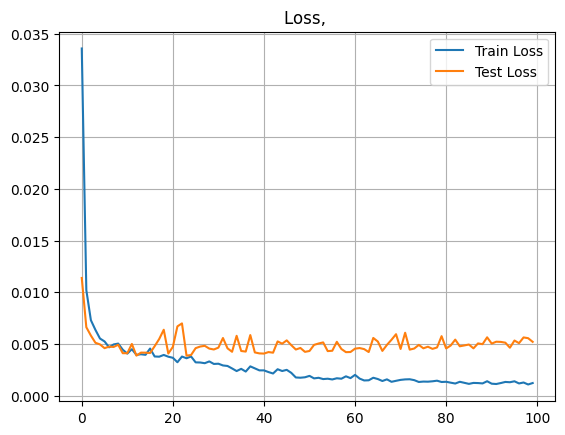

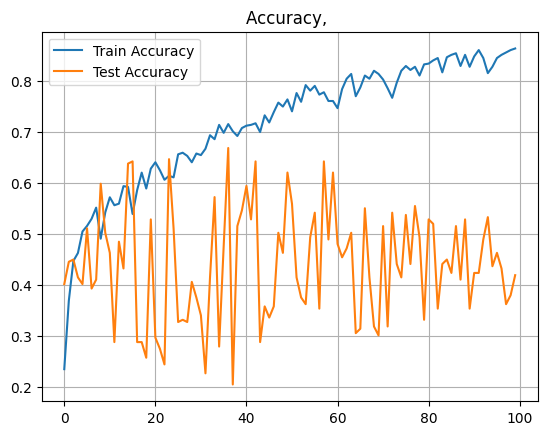

In [38]:
utils.plot_graph(*best_history)


# -----------------

In [14]:
train_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"train_dict_{suffix}.pkl"))
test_dict = utils.load_pickle(os.path.join(Hypers.Config.data_path, f"test_dict_{suffix}.pkl"))
print(f"{len(train_dict)=}", f"{len(test_dict)=}")
print(suffix)

len(train_dict)=34 len(test_dict)=3
Ret


In [15]:
input_size = len(next(iter(next(iter(train_dict.values())).values()))[0]) // window_size
print(f"{input_size=}")

input_size=38


Vaild Epoch 99: 100%|██████████| 100/100 [00:12<00:00,  7.72it/s, Loss: 0.016]


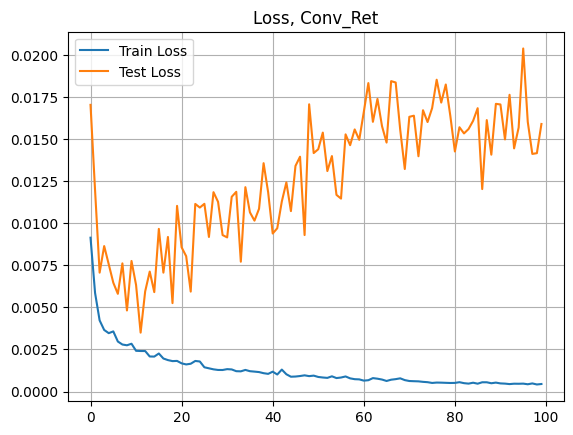

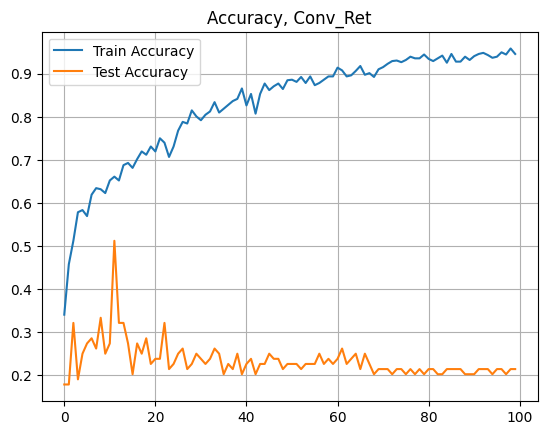

In [16]:
train_set = ConvDataset.ConvDataset(train_dict, window_size=window_size)
valid_set = ConvDataset.ConvDataset(test_dict, window_size=window_size)
train_loader = DataLoader(train_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)
valid_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=True, collate_fn=ConvDataset.ConvDataset.custom_collate_fn)

model = ConvModel.ConvModel(feature_size=input_size)
criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=Hypers.Config.learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer = Trainer.Trainer(model=model,
                          criterion=criterion,
                          optimizer=optimizer,
                          device=device,
                          train_loader=train_loader,
                          valid_loader=valid_loader,
                          model_type=model_type)
train_loss, train_accuracy, valid_loss, valid_accuracy = trainer.train_loop()
utils.plot_graph(train_loss, train_accuracy, valid_loss, valid_accuracy, identifier=f"{model_type}_{suffix}")

# Infer

In [17]:
import Inferencer
importlib.reload(Inferencer)

<module 'Inferencer' from 'c:\\Users\\Ryo\\Desktop\\PNC_Capstone\\Inferencer.py'>

In [18]:
import RegressionDataset
importlib.reload(RegressionDataset)
import RegressionModel
importlib.reload(RegressionModel)

test_loader = DataLoader(valid_set, batch_size=Hypers.Config.batch_size, shuffle=False, collate_fn=RegressionDataset.RegressionDataset.custom_collate_fn)
inferencer = Inferencer.Inferencer(model=model, test_loader=test_loader, device=device)
predictions, turths, accuracy, diff_counter = inferencer.infer()

In [19]:
nums = 10
print(predictions[:nums])
print(turths[:nums])

tensor([5., 5., 5., 4., 4., 5., 4., 4., 4., 4.])
tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])


In [20]:
print(diff_counter)

Counter({1.0: 44, 0.0: 18, 2.0: 18, 4.0: 3, 3.0: 1})


In [21]:
total_count = sum(diff_counter.values())
print(f"{total_count=}")

total_count=84


In [22]:
accumulated_count = []

for i in range(0, 33):
    count = diff_counter[i]
    if i==0:
        accumulated_count.append(count)
        continue
    accumulated_count.append(accumulated_count[-1]+count)

accumulated_accuracy = [i/total_count for i in accumulated_count]
accumulated_accuracy[:5]

[0.21428571428571427,
 0.7380952380952381,
 0.9523809523809523,
 0.9642857142857143,
 1.0]

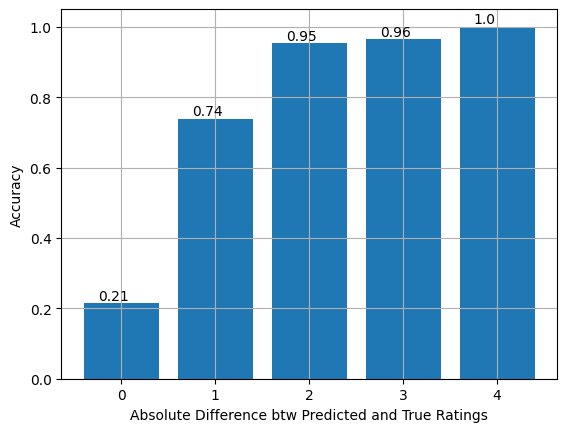

In [23]:
import matplotlib.pyplot as plt

plt.bar(range(0,5), accumulated_accuracy[:5])
for i, v in enumerate(accumulated_accuracy[:5]):
    plt.text(i - 0.25, v + 0.01, str(round(v, 2)))
plt.xlabel("Absolute Difference btw Predicted and True Ratings")
plt.ylabel("Accuracy")
plt.grid()
plt.show()